In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import struct

In [2]:
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['pcolor.shading'] = 'flat'

KeyError: 'pcolor.shading is not a valid rc parameter (see rcParams.keys() for a list of valid parameters)'

In [3]:
def fi2(fi1,teta1,azimuth,delta):
    term1 = np.cos(delta)*np.sin(fi1)*np.cos(teta1)
    factor2 = np.sin(delta)*np.cos(azimuth)*np.sin(teta1)
    term2 = factor2*np.sin(fi1)
    factor3 = np.sin(delta)*np.sin(azimuth)
    term3 = factor3*np.cos(fi1)
    teller = term1 - term2 + term3
    term1 = np.cos(delta)*np.cos(fi1)*np.cos(teta1)
    term2 = factor2*np.cos(fi1)
    term3 = factor3*np.sin(fi1)
    rnoemer = term1 - term2 - term3
    return np.arctan2(teller,rnoemer)

def teta2(teta1,azimuth,delta):
    term1 = np.cos(delta)*np.sin(teta1)
    term2 = np.sin(delta)*np.cos(azimuth)*np.cos(teta1)
    som = term1 + term2
    return np.arcsin(som)

def azdelt(teta1d,fi1d,deltad,azimuthd):
    # IO in degrees, calculations in radians
    teta1 = teta1d*np.pi/180.; fi1 = fi1d*np.pi/180.
    delta = deltad*np.pi/180.; azimuth = azimuthd*np.pi/180.
    if teta1 > 0.5*np.pi or teta1 < -0.5*np.pi:
        print('error, non-existent latitude ', teta1)
        return 0,0
    if delta < 0.:
        print('error, non-existent delta ',delta)
        return 0,0
    f = fi2(fi1,teta1,azimuth,delta)
    t = teta2(teta1,azimuth,delta)
    return t*180/np.pi, f*180/np.pi

* IMG format is binary, 16-bit, topo unit is m
* 16 pixels per degree
* got median topography from gridded data sets (randomly selected from list)

DATA_SET_ID                   = "MGS-M-MOLA-5-MEGDR-L3-V1.0" <br>
PRODUCT_ID                    = "MEGT90N000EB.IMG"           <br>
SPACECRAFT_NAME               = "MARS GLOBAL SURVEYOR"       <br>
INSTRUMENT_ID                 = MOLA                         <br>
INSTRUMENT_NAME               = "MARS ORBITER LASER ALTIMETER" <br>

Relevant web site: https://pds-geosciences.wustl.edu/dataserv/default.htm
Select MGS --> MOLA --> MEGDR --> submit 
Returns a long list of .IMG files. I randomly selected one (MEGT90N000EB.IMG); it appears to be the whole planet's median topography.

In [4]:
ppd = 16        # 16 pixels per degree
inc = 1/ppd     # increment (in degrees) between topo values
hinc = 0.5*inc
nlats = 180*ppd
nlons = 360*ppd
topom = np.zeros([nlats,nlons])
# for the quadrilateral interpretation of np.pcolormesh (shading='flat') the lat and lon array need to mark 
# the boundaries of the quadrilaterals and thus each have one more element than there are pixel (topo) values
# gmt calls this grid(line) registration
lats = np.arange(90,-90-inc,-inc)
lons = np.arange(0,360+inc,inc)
# for pixel registration (needed for xarray and imshow, for example):
plats = np.arange(90-hinc,-90-hinc,-inc)
plons = np.arange(hinc,360+hinc,inc)

In [5]:
datablock = open('megt90n000eb.img','rb')

for irow in range(nlats):
    a = datablock.read(2*nlons)      # read all bytes that represent topo values for all longitudes and one latitutde
    row = struct.unpack('>5760h',a)  # read 5760 big-endian 2-byte integers from one latitude "row" of the binary file
    topom[irow] = row                # store topo values (now integers) in a row of 2D array topom

datablock.close()
topo = 0.001*topom                   # convert topo values to km

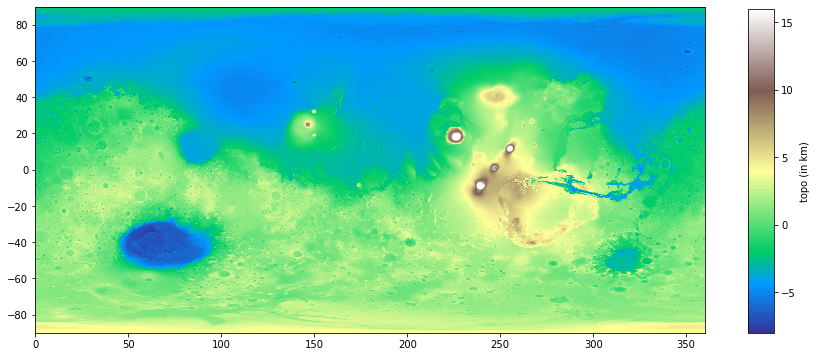

In [6]:
X,Y = np.meshgrid(lons, lats)
plt.pcolormesh(X,Y,topo,cmap='terrain',vmin=-8,vmax=16)
barea = plt.axes([0.95, 0.125, 0.03, 0.75])
plt.colorbar(cax=barea, label = 'topo (in km)')

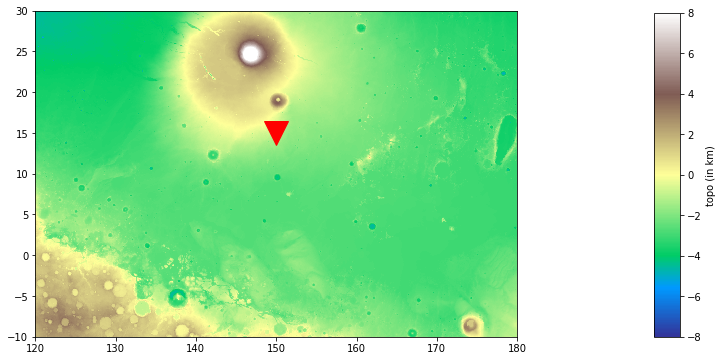

In [11]:
# plot a portion of the map between latmin and -max and lonmin  and -max:
# also limit color map to 8 km

latmin = -10; latmax = 30
lonmin = 120; lonmax = 180
y0 = (90-latmax)*16; y9 = (90-latmin)*16
x0 = lonmin*16; x9 = lonmax*16

X,Y = np.meshgrid(lons[x0:x9+1], lats[y0:y9+1])
plt.pcolormesh(X,Y,topo[y0:y9,x0:x9],cmap='terrain',vmin=-8,vmax=8)


# plot a random example point on the map:
lat1 = 15; lon1 = 150
plt.plot(lon1,lat1,'rv',markersize=24)


plt.gca().set_aspect(1/np.cos(np.radians(0.5*(latmin+latmax))))  # correct for dissimilar distance for one degree of lat and lon

barea = plt.axes([0.95, 0.125, 0.03, 0.75])
plt.colorbar(cax=barea, label = 'topo (in km)')


In [9]:
centerlon = 160; centerlat = 15

distance = 14  # degrees
azs = np.arange(0,360) # degrees
y, x = azdelt(centerlat,centerlon,distance,azs)
print("points calculated")


points calculated


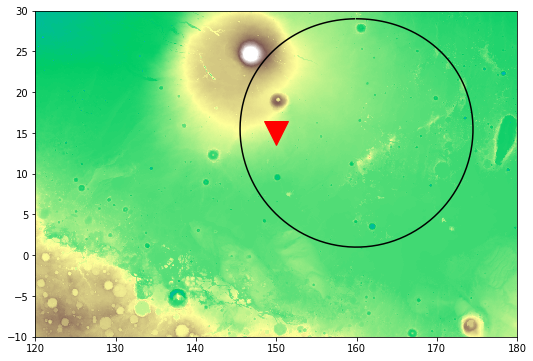

In [12]:
plt.pcolormesh(X,Y,topo[y0:y9,x0:x9],cmap='terrain',vmin=-8,vmax=8)

lat1 = 15; lon1 = 150
plt.plot(lon1,lat1,'rv',markersize=24)

plt.plot(x,y,'k',markersize=2)
plt.gca().set_aspect(1/np.cos(np.radians(0.5*(latmin+latmax))))  # correct for dissimilar distance for one degree of lat and lon




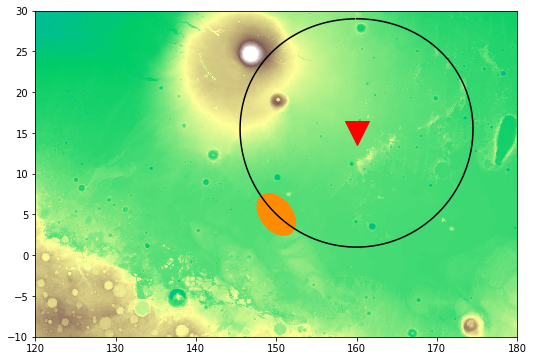

In [23]:
fig, ax = plt.subplots()

ax.pcolormesh(X,Y,topo[y0:y9,x0:x9],cmap='terrain',vmin=-8,vmax=8)

lat1 = centerlat; lon1 = centerlon
ax.plot(lon1,lat1,'rv',markersize=24)  # plot red trianlge

ax.plot(x,y,'k',markersize=2)   # plot black small  circle

e = Ellipse([150,5],width=6, height=4, angle=130)   
e.set_facecolor('darkorange')
ax.add_artist(e)

ax.set_aspect(1/np.cos(np.radians(0.5*(latmin+latmax))))  # correct for dissimilar distance for one degree of lat and lon




In [17]:
centerlon = 160; centerlat = 15

distance = 14  # degrees
azs = np.arange(0,360) # degrees
y, x = azdelt(centerlat,centerlon,distance,azs)
print("points calculated")

points calculated


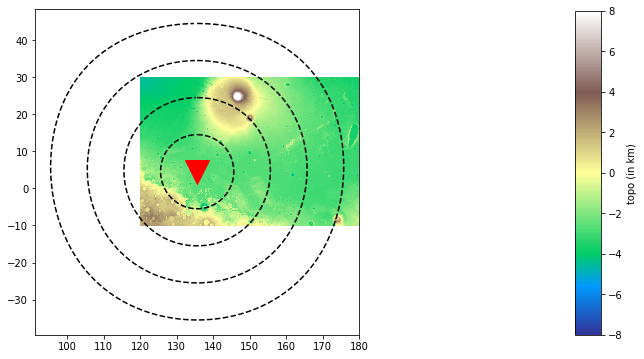

In [26]:
# plot a portion of the map between latmin and -max and lonmin  and -max:
# also limit color map to 8 km

latmin = -10; latmax = 30
lonmin = 120; lonmax = 180
y0 = (90-latmax)*16; y9 = (90-latmin)*16
x0 = lonmin*16; x9 = lonmax*16

X,Y = np.meshgrid(lons[x0:x9+1], lats[y0:y9+1])
plt.pcolormesh(X,Y,topo[y0:y9,x0:x9],cmap='terrain',vmin=-8,vmax=8)


# lander:
lat1=4.5024; long1=135.6234
plt.plot(long1,lat1,'rv',markersize=24)

# 10km circle:
for dist in [10,20,30,40]:
    y,x = azdelt(lat1, long1, dist, azs)
    plt.plot(x,y,'k--',markersize=1)


plt.gca().set_aspect(1/np.cos(np.radians(0.5*(latmin+latmax))))  # correct for dissimilar distance for one degree of lat and lon

barea = plt.axes([0.95, 0.125, 0.03, 0.75])
plt.colorbar(cax=barea, label = 'topo (in km)')
